In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd

def load_result_csv_files(directory):
    result_dfs = []
    file_paths = []
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith("results.csv"):
                file_path = os.path.join(root, filename)
                relative_path = os.path.relpath(file_path, directory)
                df = pd.read_csv(file_path)
                result_dfs.append(df)
                file_paths.append(relative_path)
    return result_dfs, file_paths

exp = "" # greedy sparse_learning movement importance weight_magnitude
directory_path = "/workdir/optimal-summaries-public/_models_train_prune/" + exp
result_dfs, file_paths = load_result_csv_files(directory_path)
len(result_dfs)

75

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [13]:
combined_df = pd.concat(result_dfs, ignore_index=True).round(3)
combined_df = combined_df[combined_df["Split"] == "test"].drop(columns=["Split"])
combined_df["Dataset"] = combined_df["Dataset"].replace({"mimic": "MIMIC", "spoken_arabic_digits": "SpokenArabicDigits", "tiselac": "Tiselac"})
combined_df["Model"] = combined_df["Model"].replace({"atomics_sum2atomics_False": "2Layers H2C", "atomics_sum2atomics_True": "2Layers H2A", "original": "Original", "shared_encode_time_dim_False": "Shared Time", "shared_encode_time_dim_True": "Shared Feature"})
combined_df["Pruning"] = combined_df["Pruning"].replace({"importance": "Importance", "movement": "Movement", "sparse_learning": "Sparse Learning", "weight_magnitude": "Weight Magnitude"})
combined_df.columns = [col.replace("Total parameter", "Total") for col in combined_df.columns]
combined_df.columns = [col.replace("Remaining parameter", "Remaining") for col in combined_df.columns]
combined_df.columns = [col.replace("Jaccard Similarity", "Jaccard") for col in combined_df.columns]
combined_df.loc[combined_df["Pruning"] == "Before", "Jaccard"] = float("NaN")

combined_df.columns

Index(['Model', 'Dataset', 'Seed', 'Pruning', 'Finetuned', 'AUC', 'ACC', 'F1',
       'Total', 'Remaining', 'Jaccard'],
      dtype='object')

## Before

In [25]:
# Model,Indicators,Summaries,Dataset,Seed,Split,AUC,ACC,F1,Cutoff,Lower threshold,Upper threshold

dataset = "SpokenArabicDigits" # MIMIC, SpokenArabicDigits, Tiselac

agg = {"AUC":["mean", "std"], "ACC":["mean", "std"], "F1":["mean", "std"], "Total":["mean"]}
per_set = combined_df[ (combined_df["Pruning"] == "Before")].drop(columns=['Seed', "Remaining", "Jaccard", "Pruning", "Finetuned"]).groupby(["Dataset", "Model"]).agg(agg).round(3)
#(combined_df["Dataset"] == dataset) &

float_format = "{:.2%}"

per_set[("AUC")] = per_set[("AUC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("AUC", "std")].map(float_format.format)
per_set[("ACC")] = per_set[("ACC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("ACC", "std")].map(float_format.format)
per_set[("F1")] = per_set[("F1", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("F1", "std")].map(float_format.format)
per_set.drop(columns=[("AUC", "mean"), ("ACC", "mean"), ("F1", "mean")], inplace=True)
per_set.columns = per_set.columns.droplevel(1)

per_set[("Total")] = per_set[("Total")].astype(int)

with open("tex/" + exp + 'before_pruning.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = per_set.to_latex(escape=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)

per_set


AUC             ACC  \
Dataset            Model                                            
MIMIC              2Layers H2A      91.20 ± 0.40%   83.40 ± 0.60%   
                   2Layers H2C      87.10 ± 0.60%   85.70 ± 0.60%   
                   Original         86.90 ± 0.90%   86.10 ± 0.50%   
                   Shared Feature   91.10 ± 0.20%   83.70 ± 0.30%   
                   Shared Time      91.80 ± 0.30%   84.50 ± 0.50%   
SpokenArabicDigits 2Layers H2A      97.50 ± 1.10%   79.90 ± 5.40%   
                   2Layers H2C      52.30 ± 4.00%   11.70 ± 2.80%   
                   Original         50.20 ± 0.30%   10.20 ± 0.30%   
                   Shared Feature   51.40 ± 0.50%   11.40 ± 0.50%   
                   Shared Time      99.90 ± 0.00%   96.80 ± 0.20%   
Tiselac            2Layers H2A      95.90 ± 0.20%   72.30 ± 0.60%   
                   2Layers H2C      95.80 ± 0.20%   72.30 ± 0.60%   
                   Original        81.10 ± 22.90%  53.70 ± 31.50%   
                   Shared Feature   96.40 ± 0.30%   74.50 ± 1.10%   
                   Shared Time      97.10 ± 0.00%   78.30 ± 0.20%   

                                               F1  Total  
Dataset            Model                                  
MIMIC              2Layers H2A      84.40 ± 0.60%    568  
                   2Layers H2C      85.90 ± 0.50%   1816  
                   Original         86.30 ± 0.40%   2628  
                   Shared Feature   84.50 ± 0.20%    132  
                   Shared Time      85.20 ± 0.40%    112  
SpokenArabicDigits 2Layers H2A      79.70 ± 5.70%   1008  
                   2Layers H2C       3.20 ± 2.10%   1584  
                   Original          2.30 ± 0.60%  10300  
                   Shared Feature    4.20 ± 0.60%    796  
                   Shared Time      96.80 ± 0.20%     56  
Tiselac            2Layers H2A      67.70 ± 0.50%    400  
                   2Layers H2C      67.70 ± 0.40%    832  
                   Original        48.20 ± 33.20%   2324  
                   Shared Feature   69.40 ± 1.10%    236  
                   Shared Time      72.90 ± 0.30%     44

## per EXP

In [27]:
# Model,Indicators,Summaries,Dataset,Seed,Split,AUC,ACC,F1,Cutoff,Lower threshold,Upper threshold

dataset = "SpokenArabicDigits" # MIMIC, SpokenArabicDigits, Tiselac

agg = {"AUC":["mean", "std"], "ACC":["mean", "std"], "F1":["mean", "std"], "Total":["mean"], "Remaining":["mean"], "Jaccard":["mean"]}
per_set = combined_df[combined_df["Dataset"] == dataset].drop(columns=["Dataset", 'Seed']).groupby(["Pruning", "Model", "Finetuned"]).agg(agg).round(3)
per_set[("Remaining / Total")] = per_set[("Remaining", "mean")].astype(int).astype(str) +" / "+ per_set[("Total", "mean")].astype(int).astype(str)
per_set.drop(columns=[("Total", "mean"), ("Remaining", "mean")], inplace=True)

float_format = "{:.2%}"

per_set[("Jaccard", "mean")] = per_set[("Jaccard", "mean")].map(float_format.format).replace("nan%", "nan")

per_set[("AUC")] = per_set[("AUC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("AUC", "std")].map(float_format.format)
per_set[("ACC")] = per_set[("ACC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("ACC", "std")].map(float_format.format)
per_set[("F1")] = per_set[("F1", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("F1", "std")].map(float_format.format)
per_set.drop(columns=[("AUC", "mean"), ("ACC", "mean"), ("F1", "mean")], inplace=True)
per_set.columns = per_set.columns.droplevel(1)
# per_set.reset_index(inplace=True)

with open("tex/" + exp + '_small.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = per_set.to_latex(escape=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)

per_set


AUC             ACC  \
Pruning          Model          Finetuned                                   
Before           2Layers H2A    False       97.50 ± 1.10%   79.90 ± 5.40%   
                 2Layers H2C    False       52.30 ± 4.00%   11.70 ± 2.80%   
                 Original       False       50.20 ± 0.30%   10.20 ± 0.30%   
                 Shared Feature False       51.40 ± 0.50%   11.40 ± 0.50%   
                 Shared Time    False       99.90 ± 0.00%   96.80 ± 0.20%   
Greedy           2Layers H2A    False      63.30 ± 23.00%  18.30 ± 14.30%   
                                True       65.10 ± 26.20%  30.30 ± 35.20%   
                 2Layers H2C    False       64.50 ± 8.70%   12.40 ± 2.70%   
                                True        67.30 ± 3.60%   18.60 ± 1.20%   
                 Original       False       83.00 ± 0.90%   10.00 ± 0.00%   
                                True       75.50 ± 13.70%   10.30 ± 0.50%   
                 Shared Feature False       64.00 ± 6.10%   10.00 ± 0.00%   
                                True        65.60 ± 7.00%   14.10 ± 5.50%   
                 Shared Time    False       99.90 ± 0.10%   96.90 ± 0.30%   
                                True        99.90 ± 0.10%   97.00 ± 0.50%   
Importance       2Layers H2A    True        90.20 ± 5.00%  58.50 ± 12.10%   
                 2Layers H2C    True        85.80 ± 5.10%  47.60 ± 13.30%   
                 Original       True        87.60 ± 3.10%   50.70 ± 7.00%   
                 Shared Feature True        99.20 ± 0.20%   88.30 ± 1.60%   
                 Shared Time    True        99.80 ± 0.00%   95.50 ± 0.20%   
Movement         2Layers H2A    True        95.80 ± 0.90%   71.40 ± 1.80%   
                 2Layers H2C    True        95.20 ± 1.50%   70.10 ± 4.20%   
                 Original       True        94.20 ± 2.50%   66.30 ± 7.80%   
                 Shared Feature True        99.90 ± 0.10%   95.50 ± 0.90%   
                 Shared Time    True        99.80 ± 0.00%   95.90 ± 0.50%   
Sparse Learning  2Layers H2A    True        98.10 ± 1.90%   84.30 ± 8.50%   
                 2Layers H2C    True        99.30 ± 0.10%   89.40 ± 1.20%   
                 Original       True        97.60 ± 0.60%   79.80 ± 3.60%   
                 Shared Feature True        99.90 ± 0.00%   96.20 ± 0.60%   
                 Shared Time    True        99.80 ± 0.00%   96.10 ± 0.50%   
Weight Magnitude 2Layers H2A    True        90.30 ± 1.50%   57.70 ± 3.60%   
                 2Layers H2C    True        90.90 ± 1.30%   58.00 ± 2.90%   
                 Original       True        77.00 ± 5.80%   31.20 ± 6.70%   
                 Shared Feature True        99.40 ± 0.30%   89.80 ± 2.40%   
                 Shared Time    True        99.80 ± 0.10%   95.90 ± 0.30%   

                                                       F1  Jaccard  \
Pruning          Model          Finetuned                            
Before           2Layers H2A    False       79.70 ± 5.70%      nan   
                 2Layers H2C    False        3.20 ± 2.10%      nan   
                 Original       False        2.30 ± 0.60%      nan   
                 Shared Feature False        4.20 ± 0.60%      nan   
                 Shared Time    False       96.80 ± 0.20%      nan   
Greedy           2Layers H2A    False      10.50 ± 15.10%    0.00%   
                                True       24.70 ± 39.70%    0.00%   
                 2Layers H2C    False        3.90 ± 1.50%    0.00%   
                                True         8.10 ± 2.10%    0.00%   
                 Original       False        1.80 ± 0.00%    0.00%   
                                True         2.30 ± 0.90%    0.00%   
                 Shared Feature False        1.80 ± 0.00%    0.00%   
                                True         6.60 ± 5.80%    0.00%   
                 Shared Time    False       96.90 ± 0.30%   92.30%   
                                True        97.00 ± 0.50%   92.30%   
Importance    

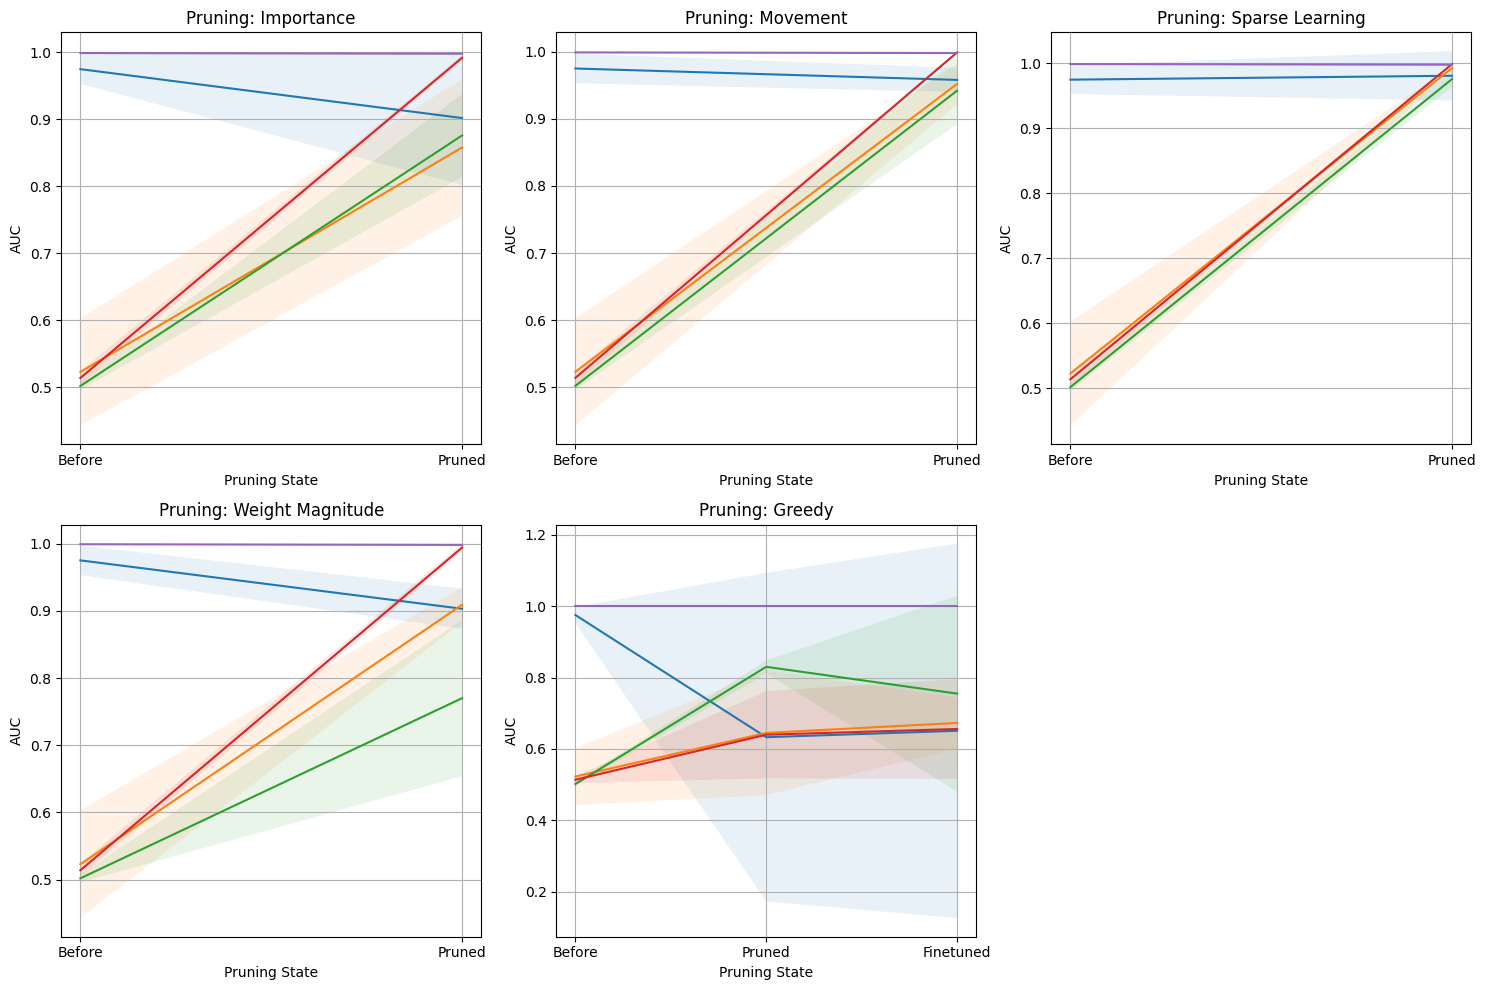

In [92]:
import matplotlib.pyplot as plt

dataset = "SpokenArabicDigits"  # MIMIC, SpokenArabicDigits, Tiselac

# Determine the number of pruning methods
pruning_methods = ["Importance", "Movement", "Sparse Learning", "Weight Magnitude", "Greedy"]
num_prunings = len(pruning_methods)

# Calculate the number of rows and columns for subplots
num_rows = (num_prunings - 1) // 3 + 1
num_cols = min(num_prunings, 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

legends = []  # List to store legend handles and labels

for i, pruning in enumerate(pruning_methods):
    agg = {"AUC": ["mean", "std"]}
    per_set = combined_df[(combined_df["Dataset"] == dataset) & (combined_df["Pruning"].isin((pruning, "Before")))] \
        .drop(columns=["Dataset", 'Seed', "Total", "Remaining", "Jaccard", "ACC", "F1"]) \
        .groupby(["Model", "Finetuned", "Pruning"]).agg(agg).round(3)

    df = per_set
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.reset_index()

    pivot_df = df.pivot(index=["Pruning", 'Finetuned'], columns="Model", values=['AUC_mean', 'AUC_std'])

    row = i // 3
    col = i % 3

    ax = axes[row, col] if num_prunings > 1 else axes

    for column in pivot_df['AUC_mean'].columns:
        ax.plot(range(len(pivot_df.index)), pivot_df['AUC_mean'][column], label=column)
        ax.fill_between(range(len(pivot_df.index)),
                        pivot_df['AUC_mean'][column] - 2 * pivot_df['AUC_std'][column],
                        pivot_df['AUC_mean'][column] + 2 * pivot_df['AUC_std'][column],
                        alpha=0.1)

    ax.set_title(f'Pruning: {pruning}')
    ax.set_xlabel('Pruning State')
    ax.set_ylabel('AUC')
    if len(pivot_df.index) == 2:
        custom_labels = ['Before', 'Pruned']
    if len(pivot_df.index) == 3:
        custom_labels = ['Before', 'Pruned', 'Finetuned']
    ax.set_xticks(range(len(pivot_df.index)))
    ax.set_xticklabels(custom_labels, rotation=0, ha='center')
    ax.grid(True)

    # Remove legend from individual subplots
    ax.legend().remove()

    # Collect legend handles and labels for each model
    handles, labels = ax.get_legend_handles_labels()
    legends.extend(zip(handles, labels))

# Add legend to the last subplot
leg_ax = axes[-1, -1]
leg_ax.axis('off')  # Hide the axis
leg_ax.legend(*zip(*legends), loc='center', title='Model')  # Add legend

# Remove any unused subplots
for i in range(num_prunings, num_rows * num_cols):
    if num_rows == 1:
        axes[i].remove()
    else:
        axes[i // num_cols, i % num_cols].remove()

plt.tight_layout()
plt.savefig("fig/Combined_Pruning_Plots.pdf", format='pdf')
plt.show()


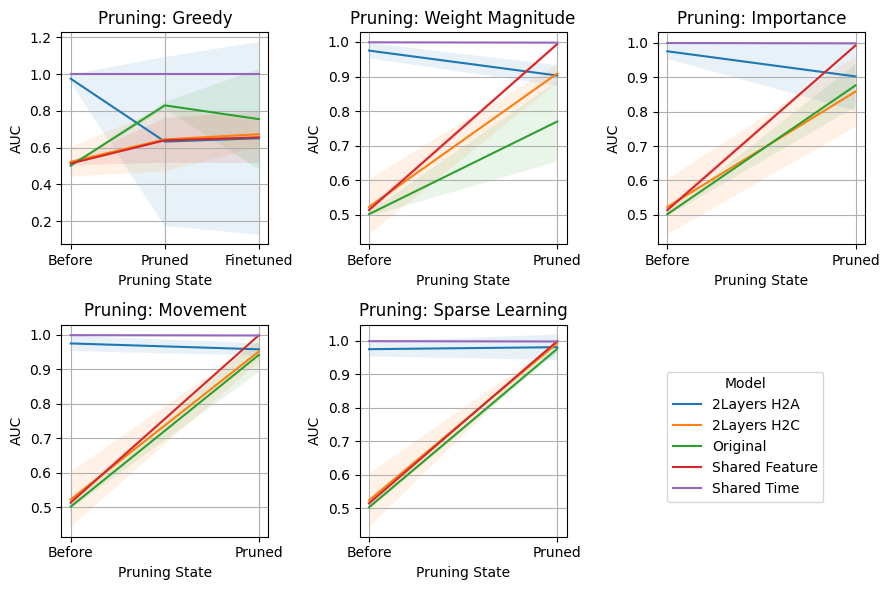

In [113]:
import matplotlib.pyplot as plt

dataset = "SpokenArabicDigits"  # MIMIC, SpokenArabicDigits, Tiselac

# Determine the number of pruning methods
num_prunings = 5  # Change this according to your dataset

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for i, pruning in enumerate(["Greedy", "Weight Magnitude", "Importance", "Movement", "Sparse Learning", "Sparse Learning"]):
    agg = {"AUC": ["mean", "std"]}
    per_set = combined_df[(combined_df["Dataset"] == dataset) & (combined_df["Pruning"].isin((pruning, "Before")))] \
        .drop(columns=["Dataset", 'Seed', "Total", "Remaining", "Jaccard", "ACC", "F1"]) \
        .groupby(["Model", "Finetuned", "Pruning"]).agg(agg).round(3)

    df = per_set
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.reset_index()

    pivot_df = df.pivot(index=["Pruning", 'Finetuned'], columns="Model", values=['AUC_mean', 'AUC_std'])

    row = i // 3
    col = i % 3

    ax = axes[row, col] if num_prunings > 1 else axes

    for column in pivot_df['AUC_mean'].columns:
        ax.plot(range(len(pivot_df.index)), pivot_df['AUC_mean'][column], label=column if pruning == "Greedy" else "")
        ax.fill_between(range(len(pivot_df.index)),
                        pivot_df['AUC_mean'][column] - 2 * pivot_df['AUC_std'][column],
                        pivot_df['AUC_mean'][column] + 2 * pivot_df['AUC_std'][column],
                        alpha=0.1)

    ax.set_title(f'Pruning: {pruning}')
    ax.set_xlabel('Pruning State')
    ax.set_ylabel('AUC')
    if len(pivot_df.index) == 2:
        custom_labels = ['Before', 'Pruned']
    if len(pivot_df.index) == 3:
        custom_labels = ['Before', 'Pruned', 'Finetuned']
    ax.set_xticks(range(len(pivot_df.index)))
    ax.set_xticklabels(custom_labels, rotation=0, ha='center')
    # ax.legend(title='Model')
    ax.grid(True)

axes[-1, -1].remove()
fig.legend(title="Model", loc=(0.75, 0.15))
plt.tight_layout()
plt.savefig("fig/Combined_Pruning_Plots.pdf", format='pdf')
plt.show()


AUC_mean                                      \
Model                2Layers H2A 2Layers H2C Original Shared Feature   
Pruning    Finetuned                                                   
Before     False           0.975       0.523    0.502          0.514   
Importance True            0.902       0.858    0.876          0.992   

                                     AUC_std                       \
Model                Shared Time 2Layers H2A 2Layers H2C Original   
Pruning    Finetuned                                                
Before     False           0.999       0.011       0.040    0.003   
Importance True            0.998       0.050       0.051    0.031   

                                                 
Model                Shared Feature Shared Time  
Pruning    Finetuned                             
Before     False              0.005         0.0  
Importance True               0.002         0.0

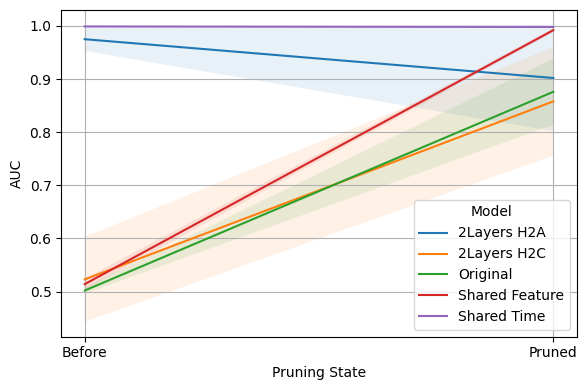

AUC_mean                                      \
Model              2Layers H2A 2Layers H2C Original Shared Feature   
Pruning  Finetuned                                                   
Before   False           0.975       0.523    0.502          0.514   
Movement True            0.958       0.952    0.942          0.999   

                                   AUC_std                       \
Model              Shared Time 2Layers H2A 2Layers H2C Original   
Pruning  Finetuned                                                
Before   False           0.999       0.011       0.040    0.003   
Movement True            0.998       0.009       0.015    0.025   

                                               
Model              Shared Feature Shared Time  
Pruning  Finetuned                             
Before   False              0.005         0.0  
Movement True               0.001         0.0

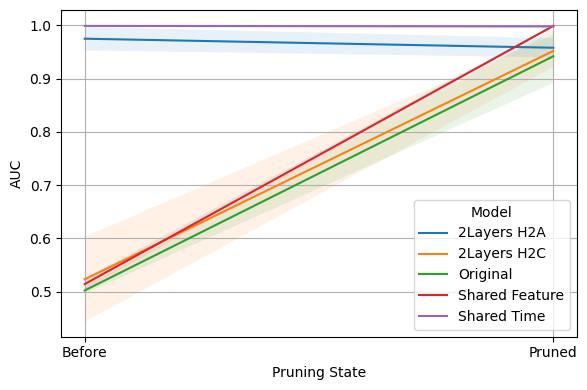

AUC_mean                                      \
Model                     2Layers H2A 2Layers H2C Original Shared Feature   
Pruning         Finetuned                                                   
Before          False           0.975       0.523    0.502          0.514   
Sparse Learning True            0.981       0.993    0.976          0.999   

                                          AUC_std                       \
Model                     Shared Time 2Layers H2A 2Layers H2C Original   
Pruning         Finetuned                                                
Before          False           0.999       0.011       0.040    0.003   
Sparse Learning True            0.998       0.019       0.001    0.006   

                                                      
Model                     Shared Feature Shared Time  
Pruning         Finetuned                             
Before          False              0.005         0.0  
Sparse Learning True               0.000         0.0

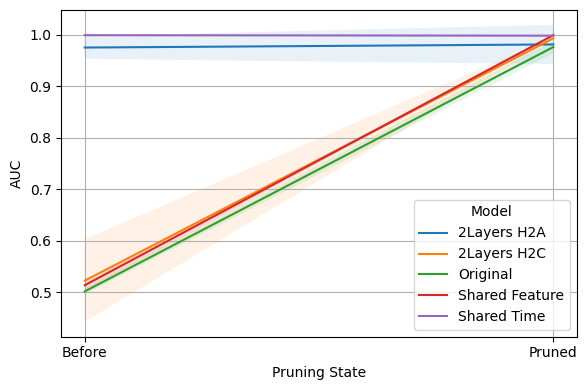

AUC_mean                                      \
Model                      2Layers H2A 2Layers H2C Original Shared Feature   
Pruning          Finetuned                                                   
Before           False           0.975       0.523    0.502          0.514   
Weight Magnitude True            0.903       0.909    0.770          0.994   

                                           AUC_std                       \
Model                      Shared Time 2Layers H2A 2Layers H2C Original   
Pruning          Finetuned                                                
Before           False           0.999       0.011       0.040    0.003   
Weight Magnitude True            0.998       0.015       0.013    0.058   

                                                       
Model                      Shared Feature Shared Time  
Pruning          Finetuned                             
Before           False              0.005       0.000  
Weight Magnitude True               0.003       0.001

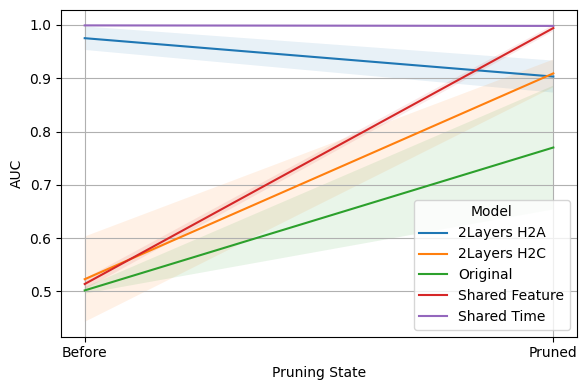

AUC_mean                                                  \
Model             2Layers H2A 2Layers H2C Original Shared Feature Shared Time   
Pruning Finetuned                                                               
Before  False           0.975       0.523    0.502          0.514       0.999   
Greedy  False           0.633       0.645    0.830          0.640       0.999   
        True            0.651       0.673    0.755          0.656       0.999   

                      AUC_std                                                  
Model             2Layers H2A 2Layers H2C Original Shared Feature Shared Time  
Pruning Finetuned                                                              
Before  False           0.011       0.040    0.003          0.005       0.000  
Greedy  False           0.230       0.087    0.009          0.061       0.001  
        True            0.262       0.036    0.137          0.070       0.001

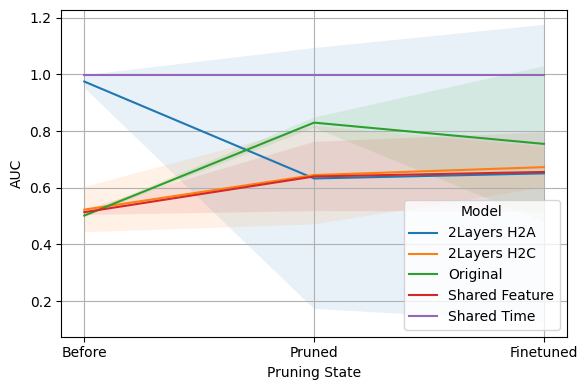

In [81]:
import matplotlib.pyplot as plt

dataset = "SpokenArabicDigits" # MIMIC, SpokenArabicDigits, Tiselac
pruning = "Sparse Learning" # Importance, Movement, Sparse Learning, Weight Magnitude, Greedy

for pruning in ["Importance", "Movement", "Sparse Learning", "Weight Magnitude", "Greedy"]:

    agg = {"AUC":["mean", "std"]} #, "ACC":["mean", "std"], "F1":["mean", "std"], "Total":["mean"], "Remaining":["mean"], "Jaccard":["mean"]}
    per_set = combined_df[(combined_df["Dataset"] == dataset) & (combined_df["Pruning"].isin( (pruning, "Before") ))] \
        .drop(columns=["Dataset", 'Seed', "Total", "Remaining", "Jaccard", "ACC", "F1"]) \
        .groupby(["Model", "Finetuned", "Pruning"]).agg(agg).round(3)

    df = per_set
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.reset_index()

    # display(df)
    pivot_df = df.pivot(index=["Pruning", 'Finetuned'], columns="Model", values=['AUC_mean', 'AUC_std'])
    # pivot_df = df.pivot(index=['Indicators', 'Summaries'], columns='Model', values=['AUC_mean', 'AUC_std'])
    display(pivot_df)

    fig, ax = plt.subplots(figsize=(6, 4))

    for column in pivot_df['AUC_mean'].columns:
        ax.plot(range(len(pivot_df.index)), pivot_df['AUC_mean'][column], label=column)
        ax.fill_between(range(len(pivot_df.index)), 
                        pivot_df['AUC_mean'][column] - 2 * pivot_df['AUC_std'][column], 
                        pivot_df['AUC_mean'][column] + 2 * pivot_df['AUC_std'][column], 
                        alpha=0.1)

    # plt.title('AUC by Model, Pruning, and Finetuning')
    plt.xlabel('Pruning State')
    plt.ylabel('AUC')
    if len(pivot_df.index) == 2:
        custom_labels = ['Before', 'Pruned']
    if len(pivot_df.index) == 3:
        custom_labels = ['Before', 'Pruned', 'Finetuned']
    plt.xticks(ticks=range(len(pivot_df.index)), labels=custom_labels, rotation=0, ha='center')
    plt.legend(title='Model')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("fig/Exp_Pruning_" + pruning + "_" + dataset + ".pdf", format='pdf')
    plt.show()

## ALL EXP

In [6]:
# Model,Indicators,Summaries,Dataset,Seed,Split,AUC,ACC,F1,Cutoff,Lower threshold,Upper threshold

agg = {"AUC":["mean", "std"], "ACC":["mean", "std"], "F1":["mean", "std"], "Total":["mean"], "Remaining":["mean"], "Jaccard":["mean"]}
per_set = combined_df.drop(columns=['Seed']).groupby(["Dataset", "Model", "Pruning", "Finetuned"]).agg(agg).round(3)
per_set[("Remaining / Total")] = per_set[("Remaining", "mean")].astype(int).astype(str) +" / "+ per_set[("Total", "mean")].astype(int).astype(str)
per_set.drop(columns=[("Total", "mean"), ("Remaining", "mean")], inplace=True)

float_format = "{:.2%}"

per_set[("Jaccard", "mean")] = per_set[("Jaccard", "mean")].map(float_format.format).replace("nan%", "nan")

per_set[("AUC")] = per_set[("AUC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("AUC", "std")].map(float_format.format)
per_set[("ACC")] = per_set[("ACC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("ACC", "std")].map(float_format.format)
per_set[("F1")] = per_set[("F1", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("F1", "std")].map(float_format.format)
per_set.drop(columns=[("AUC", "mean"), ("ACC", "mean"), ("F1", "mean")], inplace=True)
per_set.columns = per_set.columns.droplevel(1)
# per_set.reset_index(inplace=True)

with open("tex/" + exp + '_full.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = per_set.to_latex(escape=True, index=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)

per_set


AUC  \
Dataset            Model          Pruning          Finetuned                   
MIMIC              2Layers H2A    Before           False       91.20 ± 0.40%   
                                  Greedy           False       87.20 ± 2.50%   
                                                   True        89.20 ± 2.50%   
                                  importance       True        91.00 ± 0.40%   
                                  movement         True        91.00 ± 0.20%   
                                  sparse_learning  True        90.50 ± 1.60%   
                                  weight_magnitude True        91.20 ± 0.40%   
                   2Layers H2C    Before           False       87.10 ± 0.60%   
                                  Greedy           False       88.90 ± 1.90%   
                                                   True        89.10 ± 1.70%   
                                  importance       True        90.00 ± 0.90%   
                                  movement         True        90.10 ± 1.20%   
                                  sparse_learning  True        91.60 ± 0.10%   
                                  weight_magnitude True        90.90 ± 0.50%   
                   Original       Before           False       86.90 ± 0.90%   
                                  Greedy           False       91.70 ± 0.10%   
                                                   True        90.00 ± 3.00%   
                                  importance       True        90.70 ± 0.20%   
                                  movement         True        89.80 ± 2.10%   
                                  sparse_learning  True        91.40 ± 0.10%   
                                  weight_magnitude True        90.80 ± 0.10%   
                   Shared Feature Before           False       91.10 ± 0.20%   
                                  Greedy           False       80.20 ± 9.90%   
                                                   True        91.60 ± 0.40%   
                                  importance       True        91.40 ± 0.30%   
                                  movement         True        91.10 ± 0.20%   
                                  sparse_learning  True        91.50 ± 0.20%   
                                  weight_magnitude True        91.50 ± 0.10%   
                   Shared Time    Before           False       91.80 ± 0.30%   
                                  Greedy           False       92.50 ± 0.10%   
                                                   True        91.40 ± 0.20%   
                                  importance       True        91.60 ± 0.10%   
                                  movement         True        91.50 ± 0.30%   
                                  sparse_learning  True        91.70 ± 0.20%   
                                  weight_magnitude True        91.60 ± 0.20%   
SpokenArabicDigits 2Layers H2A    Before           False       97.50 ± 1.10%   
                                  Greedy           False      63.30 ± 23.00%   
                                                   True       65.10 ± 26.20%   
                                  importance       True        90.20 ± 5.00%   
                                  movement         True        95.80 ± 0.90%   
                                  sparse_learning  True        98.10 ± 1.90%   
                                  weight_magnitude True        90.30 ± 1.50%   
                   2Layers H2C    Before           False       52.30 ± 4.00%   
                                  Greedy           False       64.50 ± 8.70%   
                                                   True        67.30 ± 3.60%   
                                  importance       True        85.80 ± 5.10%   
                                  movement         True        95.20 ± 1.50%   
                                  sparse_learning  True        99.30 ± 0.10%   
                                  weight_magnitude True        90.90 ± 1.

## Grouped

In [7]:
grouped = combined_df.drop(columns=["Seed", "Dataset"]).groupby(["Pruning", "Model", "Finetuned"]).agg(agg).round(3)#.reset_index()
# grouped = grouped.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0)

with open("tex/" + exp + '_grouped.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = per_set.to_latex(escape=True, float_format="{:.2%}".format)   # df
    tex = tex.replace('%', r'\%')
    f.write(tex)

grouped

AUC           ACC            F1  \
                                            mean    std   mean    std   mean   
Pruning          Model          Finetuned                                      
Before           2Layers H2A    False      0.949  0.028  0.785  0.056  0.772   
                 2Layers H2C    False      0.784  0.192  0.566  0.327  0.523   
                 Original       False      0.727  0.208  0.500  0.361  0.456   
                 Shared Feature False      0.796  0.204  0.565  0.326  0.527   
                 Shared Time    False      0.962  0.034  0.865  0.078  0.850   
Greedy           2Layers H2A    False      0.807  0.176  0.505  0.290  0.467   
                                True       0.828  0.188  0.602  0.297  0.570   
                 2Layers H2C    False      0.810  0.132  0.474  0.309  0.428   
                                True       0.829  0.120  0.550  0.288  0.507   
                 Original       False      0.839  0.129  0.400  0.360  0.337   
                                True       0.853  0.102  0.512  0.333  0.474   
                 Shared Feature False      0.797  0.146  0.510  0.314  0.468   
                                True       0.846  0.148  0.576  0.331  0.538   
                 Shared Time    False      0.965  0.032  0.871  0.081  0.855   
                                True       0.962  0.037  0.866  0.082  0.850   
importance       2Layers H2A    True       0.913  0.027  0.688  0.132  0.675   
                 2Layers H2C    True       0.893  0.038  0.647  0.175  0.635   
                 Original       True       0.898  0.023  0.650  0.157  0.636   
                 Shared Feature True       0.954  0.034  0.815  0.074  0.802   
                 Shared Time    True       0.962  0.036  0.861  0.076  0.847   
movement         2Layers H2A    True       0.934  0.022  0.735  0.086  0.726   
                 2Layers H2C    True       0.927  0.025  0.729  0.095  0.718   
                 Original       True       0.919  0.026  0.709  0.114  0.697   
                 Shared Feature True       0.956  0.038  0.840  0.098  0.826   
                 Shared Time    True       0.961  0.037  0.862  0.077  0.848   
sparse_learning  2Layers H2A    True       0.947  0.036  0.801  0.078  0.787   
                 2Layers H2C    True       0.948  0.034  0.797  0.110  0.790   
                 Original       True       0.943  0.027  0.767  0.083  0.757   
                 Shared Feature True       0.961  0.037  0.857  0.085  0.842   
                 Shared Time    True       0.962  0.036  0.861  0.080  0.847   
weight_magnitude 2Layers H2A    True       0.916  0.016  0.690  0.123  0.678   
                 2Layers H2C    True       0.913  0.010  0.678  0.121  0.667   
                 Original       True       0.861  0.074  0.577  0.232  0.563   
                 Shared Feature True       0.955  0.034  0.823  0.078  0.810   
                 Shared Time    True       0.962  0.036  0.862  0.078  0.848   

                                                     Total Remaining Jaccard  
                                             std      mean      mean    mean  
Pruning          Model          Finetuned                                     
Before           2Layers H2A    False      0.078   658.667   658.667     NaN  
                 2Layers H2C    False      0.360  1410.667  1410.667     NaN  
                 Original       False      0.395  5084.000  5084.000     NaN  
                 Shared Feature False      0.353   388.000   388.000     NaN  
                 Shared Time    False      0.099    70.667    70.667     NaN  
Greedy           2Layers H2A    False      0.326   658.667    88.000   0.103  
                                True       0.330   658.667    88.000   0.103  
                 2Layers H2C    False      0.350  1410.667    88.000   0.101  
                                True       0.338  1410.667    88.000   0.101  
                 Original       False      0.403  5084.0